# Clustering Algorithms - K-Modes Demo

Now that you have been introduced to clustering algorithms, we will demonstrate how it is done in Python.

## Introduction
K-modes is used to cluster categorical variables. The algorithm defines clusters based on the number of matching categories between data points. This is in contrast to k-means algorithm, which clusters numerical data based on a distance measure. The step-by-step process of k-modes is as follows.

1. Pick K observations at random and use them as initial cluster values
2. Calculate the dissimilarities and assign each observation to its closest cluster
3. Define new modes for the different clusters
4. Repeat steps 2–3 until there are no re-assignments required

### Demonstration
For this demonstration, we will attempt to do k-modes clustering on the household dataset based on the health proficiency of household heads.

#### Step 1: Load the dataset
To save us time in recoding the different datasets, we can use the recoded SPSS files provided by DHS. To read the data, we need to use a **pyreadstat** python package instead of pandas. 

The code for loading the data and its dictionaries are prepared below.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pyreadstat
import pandas as pd

In [2]:
df, meta = pyreadstat.read_sav('data/PHHR71FL.SAV')
df.head()

,HHID,HV000,HV001,HV002,HV003,HV004,HV005,HV006,HV007,HV008,...,SH233X$1,SH233X$2,SH233X$3,SH233X$4,SH233X$5,SH233Z$1,SH233Z$2,SH233Z$3,SH233Z$4,SH233Z$5
0,00010001,PH7,1.0,1.0,1.0,1.0,364301.0,8.0,2017.0,1412.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00010002,PH7,1.0,2.0,4.0,1.0,364301.0,8.0,2017.0,1412.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00010004,PH7,1.0,4.0,2.0,1.0,364301.0,8.0,2017.0,1412.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00010007,PH7,1.0,7.0,2.0,1.0,364301.0,8.0,2017.0,1412.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,00010008,PH7,1.0,8.0,1.0,1.0,364301.0,8.0,2017.0,1412.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
meta.column_names_to_labels

{'HHID': 'Case Identification',
 'HV000': 'Country code and phase',
 'HV001': 'Cluster number',
 'HV002': 'Household number',
 'HV003': "Respondent's line number (answering Household questionnaire)",
 'HV004': 'Ultimate area unit',
 'HV005': 'Household sample weight (6 decimals)',
 'HV006': 'Month of interview',
 'HV007': 'Year of interview',
 'HV008': 'Date of interview (CMC)',
 'HV008A': 'Date of interview Century Day Code (CDC)',
 'HV009': 'Number of household members',
 'HV010': 'Number of eligible women in household',
 'HV011': 'NA - Number of eligible men in household',
 'HV012': 'Number of de jure members',
 'HV013': 'Number of de facto members',
 'HV014': 'Number of children 5 and under (de jure)',
 'HV015': 'Result of household interview',
 'HV016': 'Day of interview',
 'HV017': 'Number of visits',
 'HV018': 'Interviewer identification',
 'HV019': 'NA - Keyer identification',
 'HV020': 'Ever-married sample',
 'HV021': 'Primary sampling unit',
 'HV022': 'Sample strata for sampl

In [4]:
meta.variable_value_labels

{'HV003': {0.0: 'Incomplete household'},
 'HV015': {1.0: 'Completed',
  2.0: 'No Household member/no competent member at home',
  3.0: 'Entire Household absent for extended period of time',
  4.0: 'Postponed',
  5.0: 'Refused',
  6.0: 'Dwelling vacant or address not a dwelling',
  7.0: 'Dwelling destroyed',
  8.0: 'Dwelling not found',
  9.0: 'Other'},
 'HV020': {0.0: 'All woman sample', 1.0: 'Ever married sample'},
 'HV022': {1.0: 'BASILAN',
  2.0: 'CITY OF ISABELA',
  3.0: 'LANAO DEL SUR',
  4.0: 'MAGUINDANAO',
  5.0: 'COTABATO CITY',
  6.0: 'SULU',
  7.0: 'TAWI-TAWI',
  8.0: 'ABRA',
  9.0: 'APAYAO',
  10.0: 'BAGUIO CITY',
  11.0: 'BENGUET (Excluding Baguio City)',
  12.0: 'IFUGAO',
  13.0: 'KALINGA',
  14.0: 'MOUNTAIN PROVINCE',
  15.0: 'BUTUAN CITY (Capital)',
  16.0: 'AGUSAN DEL NORTE (Excluding Butuan City)',
  17.0: 'AGUSAN DEL SUR',
  18.0: 'DINAGAT ISLANDS',
  19.0: 'SURIGAO DEL NORTE',
  20.0: 'SURIGAO DEL SUR',
  21.0: 'CALOOCAN CITY',
  22.0: 'CITY OF MALABON',
  23.0: 'CIT

Do usual data cleaning.

In [5]:
df.dropna(axis = 1, how = 'all', inplace = True)
df = df.loc[:,~df.columns.str.contains('\$')]

df = df.set_index('HHID')

df.shape

(27496, 327)

#### Step 2: Selecting & engineering features 
Select relevant columns that you want to use for clustering. Since the values are binaries and categories, there is no need to do feature scaling. 

If the categories are not indexed yet, it is necessary to replace them with number indices for it to be read by the algorithm. Different ways to recode the data can be found [here](https://www.sfu.ca/~mjbrydon/tutorials/BAinPy/05_recode.html). 

It might also be better to apply one-hot encoding before we run the clustering algorithm for data processing purposes later on. For that we can use `OneHotEncoder` from sklearn.preprocessing. Here's the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)

_Note: It is still possible to account for numerical columns in k-modes. Simply [binarize](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Binarizer.html#sklearn.preprocessing.Binarizer) or [discretize](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html#sklearn.preprocessing.KBinsDiscretizer) them._

In [10]:
feature_qs = ['SH308', 'SH401', 'SH403','SH409', 'SH411', 'SH502','SH504','SH510', 'SH511', 'SH512']
data = df.loc[:, df.columns.str.contains('|'.join(feature_qs), case=False)]

for col in data.columns:
    print(f'{col}: {meta.column_names_to_labels[col]}')

SH308A: Why did you buy supplements and vitamin products advertised in television, radio or print with reminder as: Needs supplements/vitamins
SH308B: Why did you buy supplements and vitamin products advertised in television, radio or print with reminder as: Affordable
SH308C: Why did you buy supplements and vitamin products advertised in television, radio or print with reminder as: Prescribed by doctor
SH308D: Why did you buy supplements and vitamin products advertised in television, radio or print with reminder as: Prefers alternative products
SH308E: Why did you buy supplements and vitamin products advertised in television, radio or print with reminder as: Prefers traditional herbal/natural/alternative medicines
SH308F: Why did you buy supplements and vitamin products advertised in television, radio or print with reminder as: Recommended by friends,relatives
SH308G: Why did you buy supplements and vitamin products advertised in television, radio or print with reminder as: For trial


Don't forget to inspect column values to know if there's a need for encoding or recoding.

In [12]:
for col in data.columns:
    print(f'{col}: {meta.variable_value_labels[col]}')
    print(data[col].unique())
    print('-----'*10)

SH308A: {0.0: 'No', 1.0: 'Yes', 9.0: 'Missing'}
[0. 1.]
--------------------------------------------------
SH308B: {0.0: 'No', 1.0: 'Yes', 9.0: 'Missing'}
[0. 1.]
--------------------------------------------------
SH308C: {0.0: 'No', 1.0: 'Yes', 9.0: 'Missing'}
[0. 1.]
--------------------------------------------------
SH308D: {0.0: 'No', 1.0: 'Yes', 9.0: 'Missing'}
[0. 1.]
--------------------------------------------------
SH308E: {0.0: 'No', 1.0: 'Yes', 9.0: 'Missing'}
[0. 1.]
--------------------------------------------------
SH308F: {0.0: 'No', 1.0: 'Yes', 9.0: 'Missing'}
[0. 1.]
--------------------------------------------------
SH308G: {0.0: 'No', 1.0: 'Yes', 9.0: 'Missing'}
[0. 1.]
--------------------------------------------------
SH308H: {0.0: 'No', 1.0: 'Yes', 9.0: 'Missing'}
[0. 1.]
--------------------------------------------------
SH308X: {0.0: 'No', 1.0: 'Yes', 9.0: 'Missing'}
[0. 1.]
--------------------------------------------------
SH401A: {0.0: 'No', 1.0: 'Yes', 9.0: 

#### Step 3: Training initial K-Modes
Train initial K-Modes model with n_clusters = 4, and print out the `cost`.

There is also a bunch of paramaters to play around with. Here are some notes coming from the [source code](https://github.com/nicodv/kmodes/blob/master/kmodes/kmodes.py).
- `n_clusters` : int, optional, default: 8
   The number of clusters to form as well as the number of centroids to generate.
- `max_iter` : int, default: 300
   Maximum number of iterations of the k-modes algorithm for a single run.
- `cat_dissim` : func, default: matching_dissim
   Dissimilarity function used by the algorithm for categorical variables. Defaults to the matching dissimilarity function.
- `init` : {'Huang', 'Cao', 'random' or an ndarray}, default: 'Cao'
   Method for initialization:
   'Huang': Method in Huang [1997, 1998]
   'Cao': Method in Cao et al. [2009]
   'random': choose 'n_clusters' observations (rows) at random from data for the initial centroids. If an ndarray is passed, it should be of shape (n_clusters, n_features) and gives the initial centroids.
- `n_init` : int, default: 10
   Number of time the k-modes algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of cost.
- `verbose` : int, optional
   Verbosity mode.
- `random_state` : int, RandomState instance or None, optional, default: None
   If int, random_state is the seed used by the random number generator;
   If RandomState instance, random_state is the random number generator;
   If None, the random number generator is the RandomState instance used by `np.random`.
- `n_jobs` : int, default: 1
   The number of jobs to use for the computation. This works by computing each of the n_init runs in parallel. If -1 all CPUs are used. If 1 is given, no parallel computing code is used at all, which is useful for debugging. For n_jobs below -1, (n_cpus + 1 + n_jobs) are used. Thus for n_jobs = -2, all CPUs but one are used.

In [13]:
import numpy as np
from kmodes.kmodes import KModes

km = KModes(n_clusters=4, init='random', n_init=5, verbose=1)

clusters = km.fit_predict(data)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 10836, cost: 370877.0
Run 1, iteration: 2/100, moves: 3571, cost: 370877.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 9011, cost: 372413.0
Run 2, iteration: 2/100, moves: 1136, cost: 371513.0
Run 2, iteration: 3/100, moves: 966, cost: 371203.0
Run 2, iteration: 4/100, moves: 163, cost: 371203.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 11678, cost: 373536.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 9901, cost: 378042.0
Run 4, iteration: 2/100, moves: 2631, cost: 378042.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 16549, cost: 378165.0
Run 5, iteration: 2/100, moves: 3422, cost: 376020.0
Run 5, iteration

In [20]:
# Print the cluster centroids
pd.DataFrame(km.cluster_centroids_, columns = data.columns)

,SH308A,SH308B,SH308C,SH308D,SH308E,SH308F,SH308G,SH308H,SH308X,SH401A,...,SH511Z,SH512A,SH512B,SH512C,SH512D,SH512E,SH512F,SH512G,SH512X,SH512Z
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Cost is the sum of all the dissimilarities between the clusters.

In [21]:
print("Cost: " + str(km.cost_))

Cost: 370877.0


In [22]:
# We can still print silhoutte score but does it make sense?
# from sklearn.metrics import silhouette_score

# s_score = silhouette_score(data, clusters)
# print("Silhouette: " + str(s_score))

Silhouette: 0.014535524828986552


#### Step 4: Tuning the K-Modes model 
Tune the model by trying different values for `n_clusters` between 3-20 and plot the results to determine the best parameter.

In [25]:
# Elbow curve to find optimal K
cost = []
# sil = []

for num_clusters in range(3,20):
    kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 5, verbose=1)
    y_pred = kmode.fit_predict(data)
    cost.append(kmode.cost_)
#     sil.append((num_clusters, silhouette_score(data, y_pred)))

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 12616, cost: 378660.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 6555, cost: 383531.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 10994, cost: 379794.0
Run 3, iteration: 2/100, moves: 499, cost: 379794.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 11388, cost: 381031.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 13247, cost: 378263.0
Run 5, iteration: 2/100, moves: 3276, cost: 378263.0
Best run was number 5
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 8810, cost: 373155.0
Run 1, iteration: 2/100, moves: 3505, cost: 372167.0
Run 1, iteration: 

Starting iterations...
Run 4, iteration: 1/100, moves: 16590, cost: 351287.0
Run 4, iteration: 2/100, moves: 1642, cost: 349871.0
Run 4, iteration: 3/100, moves: 907, cost: 349871.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 14499, cost: 351415.0
Run 5, iteration: 2/100, moves: 225, cost: 351415.0
Best run was number 4
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 15986, cost: 348238.0
Run 1, iteration: 2/100, moves: 2663, cost: 348043.0
Run 1, iteration: 3/100, moves: 117, cost: 348043.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 14652, cost: 351018.0
Run 2, iteration: 2/100, moves: 3281, cost: 348399.0
Run 2, iteration: 3/100, moves: 2021, cost: 348098.0
Run 2, iteration: 4/100, moves: 166, cost: 348018.0
Run 2, iteration: 5/100, moves: 65, cost: 348018.0
Init: initializing centroids

Starting iterations...
Run 4, iteration: 1/100, moves: 14553, cost: 339511.0
Run 4, iteration: 2/100, moves: 2757, cost: 339383.0
Run 4, iteration: 3/100, moves: 87, cost: 339312.0
Run 4, iteration: 4/100, moves: 13, cost: 339312.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 13782, cost: 343966.0
Run 5, iteration: 2/100, moves: 503, cost: 343759.0
Run 5, iteration: 3/100, moves: 318, cost: 343308.0
Run 5, iteration: 4/100, moves: 92, cost: 343308.0
Best run was number 4
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 15948, cost: 340487.0
Run 1, iteration: 2/100, moves: 2442, cost: 340214.0
Run 1, iteration: 3/100, moves: 280, cost: 339885.0
Run 1, iteration: 4/100, moves: 217, cost: 339885.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 16148, cost: 341393.0
Run 2, iteration: 2/100, moves: 

In [27]:
cost

[378263.0,
 369057.0,
 363835.0,
 361899.0,
 357901.0,
 354392.0,
 354175.0,
 349871.0,
 345859.0,
 346848.0,
 345375.0,
 341507.0,
 339477.0,
 339312.0,
 338264.0,
 337095.0,
 335173.0]

Text(0.5, 1.0, 'Silhouetter Score Curve')

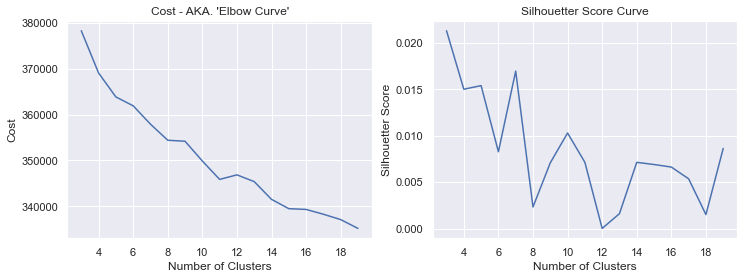

In [29]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

# Plotting Elbow Curve
x_cost = list(range(3,20))
y_cost  = cost
ax[0].plot(x_cost, y_cost)
ax[0].set_xlabel('Number of Clusters')
ax[0].set_ylabel('Cost')
ax[0].set_title("Cost - AKA. 'Elbow Curve'")

# Plotting Silhouette Score - just to see how it's very low coz based of distances of binary features
# x_sil = [x[0] for x in sil]
# y_sil  = [x[1] for x in sil]
# ax[1].plot(x_sil, y_sil)
# ax[1].set_xlabel('Number of Clusters')
# ax[1].set_ylabel('Silhouetter Score')
# ax[1].set_title('Silhouetter Score Curve')

#### Step 5: Identify the optimal number of clusters
Apply the optimal number of clusters and append cluster labels to your original df.

In [30]:
km = KModes(n_clusters=7, init='random', n_init=5, verbose=1)
cluster_labels = km.fit_predict(data)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 11850, cost: 362832.0
Run 1, iteration: 2/100, moves: 1972, cost: 361927.0
Run 1, iteration: 3/100, moves: 205, cost: 361927.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 15035, cost: 361641.0
Run 2, iteration: 2/100, moves: 1172, cost: 361641.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 15698, cost: 359151.0
Run 3, iteration: 2/100, moves: 46, cost: 359151.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 15993, cost: 363401.0
Run 4, iteration: 2/100, moves: 552, cost: 363166.0
Run 4, iteration: 3/100, moves: 83, cost: 363166.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 16364, cost: 359900.0
Run 5, iteration: 

In [31]:
data['cluster_labels'] = cluster_labels

<ipython-input-31-b04fcd4fe3a6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cluster_labels'] = cluster_labels


#### Step 6: Inspect your different clusters

In [32]:
data[data['cluster_labels'] == 0]

,,,,,,,SH308A,SH308B,SH308C,SH308D,SH308E,SH308F,SH308G,SH308H,SH308X,SH401A,...,SH512A,SH512B,SH512C,SH512D,SH512E,SH512F,SH512G,SH512X,SH512Z,cluster_labels
HHID,HV000,HV001,HV002,HV003,HV004,HV005,,,,,,,,,,,,,,,,,,,,,
00010004,PH7,1.0,4.0,2.0,1.0,364301.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
00010008,PH7,1.0,8.0,1.0,1.0,364301.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
00010011,PH7,1.0,11.0,2.0,1.0,364301.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
00010012,PH7,1.0,12.0,2.0,1.0,364301.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
00010014,PH7,1.0,14.0,1.0,1.0,364301.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12500009,PH7,1250.0,9.0,2.0,1250.0,1245167.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
12500012,PH7,1250.0,12.0,1.0,1250.0,1245167.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
12500013,PH7,1250.0,13.0,2.0,1250.0,1245167.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [33]:
data[data['cluster_labels'] == 1]

,,,,,,,SH308A,SH308B,SH308C,SH308D,SH308E,SH308F,SH308G,SH308H,SH308X,SH401A,...,SH512A,SH512B,SH512C,SH512D,SH512E,SH512F,SH512G,SH512X,SH512Z,cluster_labels
HHID,HV000,HV001,HV002,HV003,HV004,HV005,,,,,,,,,,,,,,,,,,,,,
00010001,PH7,1.0,1.0,1.0,1.0,364301.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
00010002,PH7,1.0,2.0,4.0,1.0,364301.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
00010007,PH7,1.0,7.0,2.0,1.0,364301.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
00010013,PH7,1.0,13.0,2.0,1.0,364301.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
00010019,PH7,1.0,19.0,2.0,1.0,364301.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12470020,PH7,1247.0,20.0,2.0,1247.0,572777.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
12470022,PH7,1247.0,22.0,1.0,1247.0,572777.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
12490021,PH7,1249.0,21.0,1.0,1249.0,885452.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [34]:
data[data['cluster_labels'] == 2]

,,,,,,,SH308A,SH308B,SH308C,SH308D,SH308E,SH308F,SH308G,SH308H,SH308X,SH401A,...,SH512A,SH512B,SH512C,SH512D,SH512E,SH512F,SH512G,SH512X,SH512Z,cluster_labels
HHID,HV000,HV001,HV002,HV003,HV004,HV005,,,,,,,,,,,,,,,,,,,,,
00010010,PH7,1.0,10.0,2.0,1.0,364301.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
00010021,PH7,1.0,21.0,2.0,1.0,364301.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2
00020004,PH7,2.0,4.0,2.0,2.0,419472.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2
00020005,PH7,2.0,5.0,1.0,2.0,419472.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
00020007,PH7,2.0,7.0,2.0,2.0,419472.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12490020,PH7,1249.0,20.0,2.0,1249.0,885452.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2
12500010,PH7,1250.0,10.0,2.0,1250.0,1245167.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2
12500016,PH7,1250.0,16.0,2.0,1250.0,1245167.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


In [35]:
data[data['cluster_labels'] == 3]

,,,,,,,SH308A,SH308B,SH308C,SH308D,SH308E,SH308F,SH308G,SH308H,SH308X,SH401A,...,SH512A,SH512B,SH512C,SH512D,SH512E,SH512F,SH512G,SH512X,SH512Z,cluster_labels
HHID,HV000,HV001,HV002,HV003,HV004,HV005,,,,,,,,,,,,,,,,,,,,,
00010009,PH7,1.0,9.0,1.0,1.0,364301.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
00010015,PH7,1.0,15.0,2.0,1.0,364301.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3
00010024,PH7,1.0,24.0,2.0,1.0,364301.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3
00010027,PH7,1.0,27.0,2.0,1.0,364301.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3
00020013,PH7,2.0,13.0,1.0,2.0,419472.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12500007,PH7,1250.0,7.0,2.0,1250.0,1245167.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
12500014,PH7,1250.0,14.0,2.0,1250.0,1245167.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
12500019,PH7,1250.0,19.0,2.0,1250.0,1245167.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


In [36]:
data[data['cluster_labels'] == 4]

,,,,,,,SH308A,SH308B,SH308C,SH308D,SH308E,SH308F,SH308G,SH308H,SH308X,SH401A,...,SH512A,SH512B,SH512C,SH512D,SH512E,SH512F,SH512G,SH512X,SH512Z,cluster_labels
HHID,HV000,HV001,HV002,HV003,HV004,HV005,,,,,,,,,,,,,,,,,,,,,
00030006,PH7,3.0,6.0,2.0,3.0,209298.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4
00030018,PH7,3.0,18.0,2.0,3.0,209298.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4
00040008,PH7,4.0,8.0,2.0,4.0,368680.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4
00040012,PH7,4.0,12.0,2.0,4.0,368680.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4
00050015,PH7,5.0,15.0,1.0,5.0,192659.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12470017,PH7,1247.0,17.0,2.0,1247.0,572777.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4
12480008,PH7,1248.0,8.0,1.0,1248.0,276704.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4
12480010,PH7,1248.0,10.0,1.0,1248.0,276704.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [37]:
data[data['cluster_labels'] == 5]

,,,,,,,SH308A,SH308B,SH308C,SH308D,SH308E,SH308F,SH308G,SH308H,SH308X,SH401A,...,SH512A,SH512B,SH512C,SH512D,SH512E,SH512F,SH512G,SH512X,SH512Z,cluster_labels
HHID,HV000,HV001,HV002,HV003,HV004,HV005,,,,,,,,,,,,,,,,,,,,,
00020009,PH7,2.0,9.0,2.0,2.0,419472.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5
00030008,PH7,3.0,8.0,2.0,3.0,209298.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
00030017,PH7,3.0,17.0,3.0,3.0,209298.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5
00040010,PH7,4.0,10.0,2.0,4.0,368680.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,5
00040025,PH7,4.0,25.0,2.0,4.0,368680.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12440002,PH7,1244.0,2.0,2.0,1244.0,1945227.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
12450024,PH7,1245.0,24.0,2.0,1245.0,379084.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5
12450026,PH7,1245.0,26.0,2.0,1245.0,379084.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5


In [38]:
data[data['cluster_labels'] == 6]

,,,,,,,SH308A,SH308B,SH308C,SH308D,SH308E,SH308F,SH308G,SH308H,SH308X,SH401A,...,SH512A,SH512B,SH512C,SH512D,SH512E,SH512F,SH512G,SH512X,SH512Z,cluster_labels
HHID,HV000,HV001,HV002,HV003,HV004,HV005,,,,,,,,,,,,,,,,,,,,,
00020028,PH7,2.0,28.0,2.0,2.0,419472.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
00030007,PH7,3.0,7.0,2.0,3.0,209298.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
00030012,PH7,3.0,12.0,2.0,3.0,209298.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
00030020,PH7,3.0,20.0,2.0,3.0,209298.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
00030026,PH7,3.0,26.0,1.0,3.0,209298.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12490026,PH7,1249.0,26.0,2.0,1249.0,885452.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,6
12500020,PH7,1250.0,20.0,2.0,1250.0,1245167.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,6
12500021,PH7,1250.0,21.0,1.0,1250.0,1245167.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6


---------------------------------------
# Process Summary

__Step 1__: Import the dataset

__Step 2__: Select the columns you want to use for clustering and do necessary encoding or recoding with the use of `OneHotEncoder`, `Binarizer`, or `KBinsDiscretizer` from sklearn.preprocessing 

__Step 3:__ Train initial KModes model with `n_clusters` = 5, and print out the `cost`

__Step 4:__ Tune the model by trying different values for `n_clusters` between 3-20 and plot the results to determine the best parameter.

__Step 5:__ Apply the optimal number of clusters and append cluster labels to your original df.

__Step 6:__ Inspect which units were assigned to each group when we applied the optimal number of clusters. Nuance groups by the features used to do the clustering and by all other information available (e.g. demographics, location).